# Tracking meteorological seasons with Perceptron

The perceptron is one of the simplest types of artificial neural networks, introduced by Frank Rosenblatt in 1958. In this notebook, we use a perceptron as a simple multi-class classifier. It is first trained on predefined seasons, and then tasked with assigning each day in a new time series to one of those seasons.

In [47]:
from xseas.models.perceptron import train_perceptron, build_model
from xseas.xarray.xutils import generate_season_idx, tile_labels, get_prediction

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
# Loading sample data and apply a low-pass filter
dataset_t2m = xr.open_mfdataset('sample_data/INDIA_t2m_1980_1985.nc')['2t'].rolling(time=15, center=True).mean()
dataset_tp = xr.open_mfdataset('sample_data/INDIA_tp_1980_1985.nc')['tp'].rolling(time=15, center=True).mean()

# Uniforming the time
dataset_tp['time'] = dataset_t2m['time']

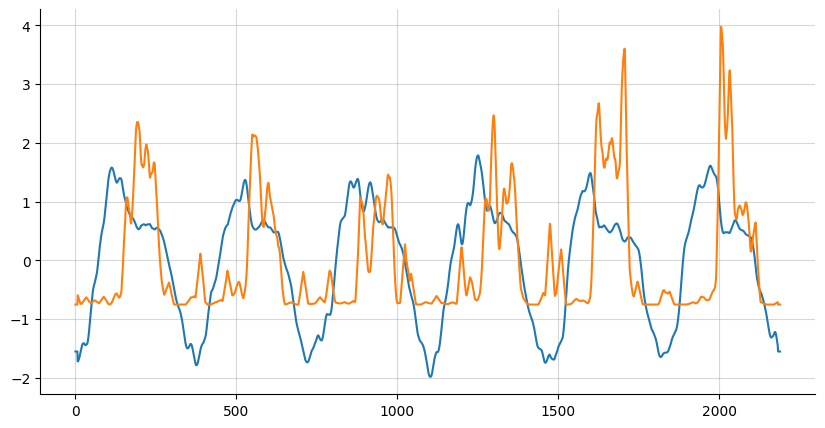

In [49]:
# Extrapolating a time-series [filling na with plausible values]
t2m_timeseries = dataset_t2m.isel(lat=20, lon=20).fillna(290).values - 273
tp_timeseries = dataset_tp.isel(lat=20, lon=20).fillna(0).values * 86400
training = np.array([t2m_timeseries, tp_timeseries]).T

# Normalizing the data
training_norm = (training - np.nanmean(training, axis=0))/np.nanstd(training, axis=0)

# Plotting the training data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(training_norm)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5)


In [50]:
# Create lables
kwargs = {'n_seas' : 2}
labels = get_prediction([150, 270], **kwargs)

# Flatten the labels and repeat for 6 years
labels = np.tile(np.concatenate(labels.reshape(-1, 1)), 6).reshape(-1, 1)

# Create a dataset with training and labels
dataset = np.column_stack([training_norm, labels])
dataset.shape

(2190, 3)

In [51]:
# Training and testing the model
model, history, test_metrics = train_perceptron(dataset, n_features=2, n_year_training=3, epochs=200, batch_size=15)
test_metrics

{'mse': 0.05457353478166875,
 'r2': 0.752702069003816,
 'accuracy': 0.9232876896858215}

In [52]:
# Making a prediction on the last year
pred = model.predict(dataset[-365 * 2:, :2]).argmax(axis=1)
dataset_result = np.column_stack([training[-365*2:,:], pred])
dataset_result = pd.DataFrame(dataset_result, columns=['Temperature [°C]', 'Precipitazione [mm/day]', 'Season'])

# Some statistics
dataset_result.groupby('Season').mean()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


,Temperature [°C],Precipitazione [mm/day]
Season,,
0.0,24.132106,0.591498
1.0,28.899735,8.943028


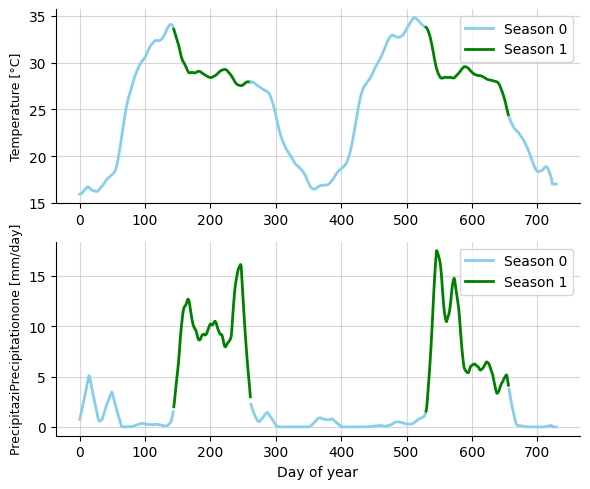

In [53]:
# Plotting the time series
df = dataset_result
df['Season'] = df['Season'].astype(int)
colors = {0: 'skyblue', 1: 'green'}

fig, ax = plt.subplots(2,1, figsize=(6, 5))
start = 0
for i in range(1, len(df)):

    if df['Season'].iloc[i] != df['Season'].iloc[i-1] or i == len(df)-1:
        end = i + 1 if i == len(df)-1 else i
        season = df['Season'].iloc[start]
        ax[0].plot(range(start, end), df['Temperature [°C]'].iloc[start:end], color=colors.get(season, 'black'), linewidth=2)
        ax[1].plot(range(start, end), df['Precipitazione [mm/day]'].iloc[start:end], color=colors.get(season, 'black'), linewidth=2)
        start = i


for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid(alpha=0.5)

    legend_labels = [plt.Line2D([0], [0], color=c, lw=2, label=f'Season {s}') for s, c in colors.items()]
    a.legend(handles=legend_labels)


ax[1].set_xlabel('Day of year')

ax[0].set_ylabel('Temperature [°C]', fontsize=9)
ax[1].set_ylabel('PrecipitaziPrecipitationone [mm/day]', fontsize=9)

plt.tight_layout()